# [ELE 075] Sistemas Nebulosos: Atividade Prática 1
__Alunos:__
- Hernane Braga Pereira - 2014112627
- Luiza Abreu - 2014089099

__Comentários:__
As imagens para a tarefa 3 foram renomeadas a fim de facilitar o funcionamento do script sem que seja necessário chamá-las hardcoded

__TAREFAS:__

__[1] Fuzzy C-Means:__ 

Implemente o algoritmo de agrupamento Fuzzy C-Means (FCM).

__[2] Validação do FCM:__ 

Valide o algoritmo FCM com a base de dados “FCMdataset.csv”. Para a validação, plote os centros dos clusters encontrados pelo algoritmo FCM sobre a base de dados fornecida.

__[3] Segmentação de Imagens por Região:__ 

Use o algoritmo FCM para fazer segmentação semântica das imagens RGB fornecidas no diretório ImagensTeste. Para cada imagem, escolha o número de clusters de forma empírica, com base na observação do número de regiões distintas (em termos de tonalidades de cor) que a imagem possui. Após obter a matriz de partição _U_, resultado da aplicação do FCM em cada imagem, use esta matriz para colorir cada região (cluster) com a tonalidade do pixel que corresponde ao centro da região. Os pixels 1 que apresentarem maior grau de compatibilidade (pertinência) a uma dada região devem ser coloridos com a tonalidade do pixel central daquela região.

__Loading libraries__

In [1]:
import os
import glob 
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import linalg as LA
from matplotlib import pyplot as plt 
import skimage.io as io

Arquivos utilizados:

In [2]:
example_path = 'data/example.csv'
validation_path = 'data/fcm_dataset.csv'
imagePath = 'data/ImagensTeste/'

# 1.Fuzzy C-Means

Para criar a função fuzzy means será usado um conjunto de dados sintéticos e bem separados para ver o comportamento do algoritmo.

Feito usando: https://drawdata.xyz/

In [3]:
data_example = pd.read_csv(example_path)

x = data_example.iloc[:,0:2].to_numpy()

Database shape: (14, 3)


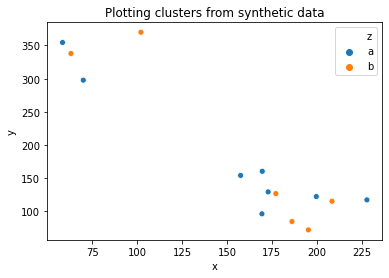

In [4]:
print("Database shape:", data_example.shape)
sns.scatterplot(data=data_example, x='x', y='y', hue='z')
plt.title("Plotting clusters from synthetic data"), plt.legend()
plt.show()

## Inicializando matriz de pertencimento $U$ 

A matriz de pertenciamento $U$ mapeia a relação de cada amostra para cada $c$ clusters definidos, seu formato é $n$ $x$ $c$ e ela será inicializada com valores aleatórios, onde cada linha somada tem o total de 1.

$$\sum_{c=1}^{C} u_{i, c} = 1, \forall{i} = 1 ,..., n$$

In [5]:
def initialise_U_matrix(n, c):
    """ Returns a randomly U matrix where the sum of each row = 1
        Args: n: number os samples, c: number of clusters
    """
    U_matrix = np.random.rand(n, c)
    return U_matrix/U_matrix.sum(axis=1)[:,None]

In [6]:
max_rows = 3 
c = 2
U = initialise_U_matrix(x.shape[0], c)
print("U matrix shape:", U.shape)
print("\nFirst elements from matrix U: \n", U[0:max_rows])
print("Sum of row [0]:", np.sum(U[0,:]))

U matrix shape: (14, 2)

First elements from matrix U: 
 [[0.48903839 0.51096161]
 [0.53267957 0.46732043]
 [0.37459894 0.62540106]]
Sum of row [0]: 1.0


## Computando os centroides de cada cluster

Os centroides são calculados da seguinte forma:

$$\overrightarrow{\rm c_k} = \frac{ \sum_{i=1}^{n} (u_{i, c})^{r} (\overrightarrow{\rm x_i})} {\sum_{i=1}^{n} (u_{i, c})^{r}} $$

In [7]:
def calc_centroid(x, U, r=2):
    """ Calculate the clusters centroid.
        Args: x: normalized data, U: membership matrix, r: c-means algorithm parameter (default=2)
    """
    centroid = np.empty((U.shape[1], x.shape[1]))

    for i in np.arange(len(centroid)):
        numerator = np.dot(np.power(U[:,i], r), x)
        denominator = np.sum(np.power(U[:,i], r))
        centroid[i, :] = numerator/denominator

    return centroid

Centroid for each c cluster:
[[156.79870584 173.65663379]
 [154.27695141 184.49054368]]


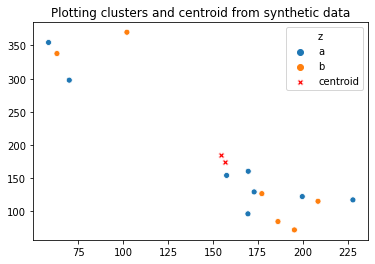

In [8]:
r = 2
centroid = calc_centroid(x, U, r)
print("Centroid for each c cluster:")
print(centroid)

sns.scatterplot(x=x[:,0], y=x[:,1], hue=data_example['z'])
sns.scatterplot(x=centroid[:,0], y=centroid[:,1], color='red', marker='X', label='centroid')
plt.title("Plotting clusters and centroid from synthetic data"), plt.legend()
plt.show()

## Atualizar matrix de pertencimento $U$

Esta etapa está divida em 2 funções: a primeira atualiza o valor do elmento $u_{i,j}$, enquanto a segunda atualiza o valor da matriz de pertencimento $U$.

$u_{i,j} =  \frac{(\frac{1}{dist(x_i, c_j)})^{\frac{1}{r-1}}}{\sum_{k=1}^{C}(\frac{1}{dist(x_i, c_k)})^{\frac{1}{r-1}}}$

_Referência:_ http://www.cleartheconcepts.com/fuzzy-c-means/

In [9]:
def update_uij(xi, cj, centroid, r=2):
    """ Returns the updated uij element of the U matrix
        Args: xi: sample i to be evaluated, cj: cluster j to be evaluated 
              centroid: ndarray of centroids, r: c-means algorithm parameter (default=2)
    """
    numerator = np.power(1/LA.norm(xi-cj), (1/(r-1)))

    denominator = 0
    for k in np.arange(centroid.shape[0]):
        denominator+= 1/LA.norm(xi - centroid[k, :])
        
    updated_value = numerator/(np.power(denominator, (1/(r-1)))) 
    return updated_value

In [10]:
def update_U_matrix(x, U, centroid, r=2):
    """ Returns the updated U matrix
        Args: x: normalized data, U: membership matrix
              centroid: ndarray of centroids, r: c-means algorithm parameter (default=2)
    """
    for j in np.arange(U.shape[1]):
        for i in np.arange(U.shape[0]):
            U[i,j] = update_uij(x[i, :], centroid[j,:], centroid, r)
    return U

In [11]:
max_rows = 3
print('Firt elements from U matrix:\n', U[0:max_rows])
print("Sum of row [0] U matrix:", np.sum(U[0,:]))

updated_U = update_U_matrix(x, U, centroid, r)
print('\n\nFirt elements from Update U matrix:\n', updated_U[0:max_rows])
print("Sum of row [0] update U matrix:", np.sum(updated_U[0,:]))

Firt elements from U matrix:
 [[0.48903839 0.51096161]
 [0.53267957 0.46732043]
 [0.37459894 0.62540106]]
Sum of row [0] U matrix: 1.0


Firt elements from Update U matrix:
 [[0.53306223 0.46693777]
 [0.48598516 0.51401484]
 [0.48665688 0.51334312]]
Sum of row [0] update U matrix: 1.0


## Avaliando se a diferença entre as duas matrizes de pertencimento está dentro do critério estabelido $\epsilon$

In [12]:
def check_difference(present, updated, epsilon):
    """ Check the difference on centroid update. Return true if is less then epsilon
    """
    difference = np.empty((present.shape[0]), dtype=present.dtype)
    for i in np.arange(len(difference)):
        difference[i] = LA.norm(present[i,:] - updated[i,:])

    if (difference.max() <= epsilon):
        return True
    return False

In [13]:
new_centroid = calc_centroid(x, updated_U, r)
epsilon = 0.001
print("Difference between centroids from cluster [0]:", LA.norm(centroid[0,:] - new_centroid[0,:] ))
print("Difference between centroids from cluster [1]:", LA.norm(centroid[1,:]  - new_centroid[1,:] ))
print("Less then epsilon?", check_difference(centroid, new_centroid, epsilon))


Difference between centroids from cluster [0]: 1.9014046717295041
Difference between centroids from cluster [1]: 8.98997321613131
Less then epsilon? False


## Juntando as funções em uma única função _fuzzy_c_means_ 


In [14]:
def fuzzy_c_means(x, c, epsilon, r=2):
    """ Compute the c clusters to a dataset x using fuzzy logic 
        Args: x - dataset to be processed, c - number of clusters, epsilon - difference between two iterations
                  max_steps - max iterations allowed, r: c-means algorithm parameter (default=2)
        Return: U - membership matrix to each cluster, centroid - a ndarray with centers of each cluster
    """
    stop = False
    U = initialise_U_matrix(x.shape[0], c)
    centroid = calc_centroid(x, U, r)
    while (stop == False):
        U = update_U_matrix(x, U, centroid, r)  
        new_centroid = calc_centroid(x, U, r)
        
        stop = check_difference(centroid, new_centroid, epsilon)
        centroid = new_centroid
        
    return U, centroid

In [15]:
epsilon = 0.001
r = 2
c = 2

data_example = pd.read_csv(example_path)
x = data_example.iloc[:,0:2].to_numpy()

U, centroid = fuzzy_c_means(x, c, epsilon, r)

In [16]:
df = pd.DataFrame(U)
maxValuesObj = df.idxmax(axis=1)
def LabelData(maxValuesObj, data):
    for i in range(len(maxValuesObj)):
        data.z[i] = maxValuesObj[i]
LabelData(maxValuesObj, data_example)

<ipython-input-16-ea1cdcb9d538>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.z[i] = maxValuesObj[i]


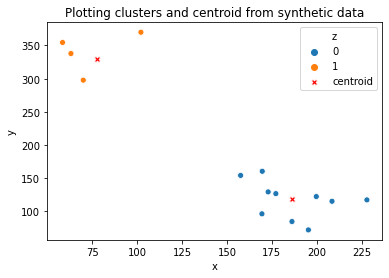

In [17]:
df=pd.DataFrame(data_example)
sns.scatterplot(data=data_example, x='x', y='y', hue='z')
sns.scatterplot(x=centroid[:,0], y=centroid[:,1], color='red', marker='X', label='centroid')
plt.title("Plotting clusters and centroid from synthetic data"), plt.legend()
plt.show()

------------

# 2.Validação do FCM:

O algoritmo FCM será validado utilizando a base de dados "FCMdataset.csv". Será plotado os centros dos clusters encontrados pelo algoritmo sobre a base de dados fornecida.

Carregando os dados:

In [18]:
validation_data = pd.read_csv(validation_path)

x = validation_data.iloc[:,0:2].to_numpy()
validation_data['z'] = ""

No handles with labels found to put in legend.


Database shape: (800, 3)


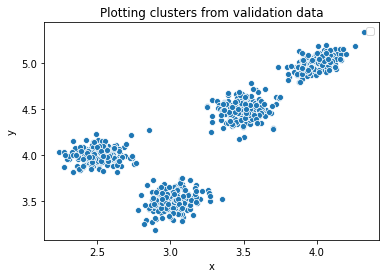

In [19]:
print("Database shape:", validation_data.shape)
sns.scatterplot(data=validation_data, x='x', y='y')
plt.title("Plotting clusters from validation data"), plt.legend()
plt.show()

In [20]:
max_rows = 3 
c = 4
U = initialise_U_matrix(x.shape[0], c)
print("U matrix shape:", U.shape)
print("\nFirst elements from matrix U: \n", U[0:max_rows])
print("Sum of row [0]:", np.sum(U[0,:]))

U matrix shape: (800, 4)

First elements from matrix U: 
 [[0.03192145 0.37331485 0.33861336 0.25615035]
 [0.08892909 0.26495536 0.30049837 0.34561718]
 [0.30175841 0.10771555 0.4176898  0.17283623]]
Sum of row [0]: 1.0


Utilizando a função de Fuzzy CMeans desenvolvida: 

In [21]:
epsilon = 0.001
r = 2
c = 4

U, centroid = fuzzy_c_means(x, c, epsilon, r)

In [22]:
df = pd.DataFrame(U)
maxValuesObj = df.idxmax(axis=1)
for i in range(len(maxValuesObj)):
    validation_data.z[i] = maxValuesObj[i]

<ipython-input-22-f78a5c64cd8d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data.z[i] = maxValuesObj[i]


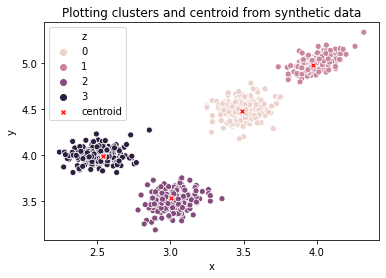

In [23]:
df=pd.DataFrame(validation_data)
sns.scatterplot(data=validation_data, x='x', y='y', hue='z')
sns.scatterplot(x=centroid[:,0], y=centroid[:,1], color='red', marker='X', label='centroid')
plt.title("Plotting clusters and centroid from synthetic data"), plt.legend()
plt.show()

-------

## 3.Segmentação de Imagens por Região:

Use o algoritmo FCM para fazer segmentação semântica das imagens RGB fornecidas no diretório ImagensTeste. Para cada imagem, escolha o número de clusters de forma empírica, com base na observação do número de regiões distintas (em termos de tonalidades de cor) que a imagem possui. Após obter a matriz de partição _U_, resultado da aplicação do FCM em cada imagem, use esta matriz para colorir cada região (cluster) com a tonalidade do pixel que corresponde ao centro da região. Os pixels 1 que apresentarem maior grau de compatibilidade (pertinência) a uma dada região devem ser coloridos com a tonalidade do pixel central daquela região.

Inicialmente, fizemos as importações necessárias e definimos uma função responsável pela visualização da imagem:

In [24]:
def Show(img):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    plt.show()

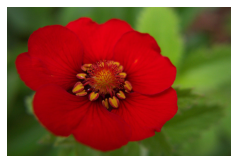

In [25]:
img =io.imread(os.path.join(imagePath,'2-1.jpg'))
Show(img)

Checando as proporções da imagem, percebemos que cada pixel é formado por 3 canais de cores (r,g,b) distribuídos em uma matriz. Para utilizar o algoritmo que foi implementado, consideramos o que antes era considerado como as coordenadas "x" e "y" como cada um dos canais de cor "r", "g" e "b". Precisamos então fazer a imagem deixar de ter as proporções de uma matriz para serem apresentadas em uma lista. 

De maneira análoga ao problema inicialmente tratado onde o algoritmo atuou em uma lista de pontos com 2 informações de posição, utilizaremos uma lista de pixels com 3 informações referentes aos canais de cor.

In [26]:
print("proporções iniciais da imagem:" + str(img.shape))
reshapedImg = img.reshape(((427*640), -1))
print("Imagem com novas proporções" + str(reshapedImg.shape))

proporções iniciais da imagem:(427, 640, 3)
Imagem com novas proporções(273280, 3)


É utilizada então a função desenvolvida para realizar a segmentação da imagem. Considera-se que a imagem deve apresentar 2 centros distintos uma vez que a imagem possui duas cores predominantes.

In [27]:
epsilon = 0.9
r = 2
c = 2

imageU, imageCentroid = fuzzy_c_means(reshapedImg, c, epsilon, r)

Analisa-se então quais os valores máximos encontrados na matriz de pertencimento imageU

In [28]:
imageDf = pd.DataFrame(imageU)
imageMaxValuesObj = imageDf.idxmax(axis=1)

A máscara de segmentação da imagem então será considerada como:
* pixels classificados como "0" receberão a cor preta [0,0,0]
* pixels classificados como "1" receberão a cor branca [255,255,255]


In [29]:
mask = imageMaxValuesObj.to_numpy()
imageMask = []
for i in range(len(mask)):
    if(mask[i] == 0):
        imageMask.append([0,0,0])
    else:
        imageMask.append([255,255,255])

Imagem segmentada para 2 clusters:


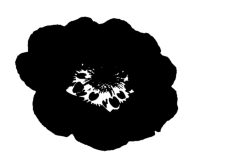

In [30]:
imageMask = np.array(imageMask)
imageMask = imageMask.reshape(427, 640, 3)
print("Imagem segmentada para 2 clusters:")
Show(imageMask)

-----------

### Generalizando para que o algortimo seja aplicado com todas as imagens:

A quantidade de classes consideradas em cada uma das imagens foi definida no nome do arquivo após análise prévia.

In [31]:
maskColor = [
    [0,0,0],
    [255, 255, 255],
    [178,34,34], 
    [255,215,0],
    [0,255,127],
    [100,149,237]
]

Quantidade de cores que serão consideradas:3
Imagem e seu respectivo histograma:


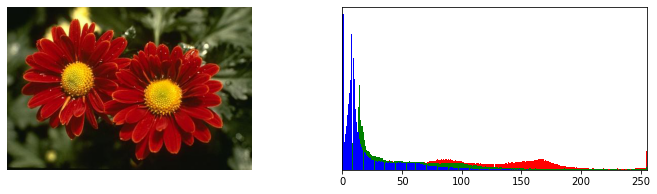

Quantidade de cores que serão consideradas:2
Imagem e seu respectivo histograma:


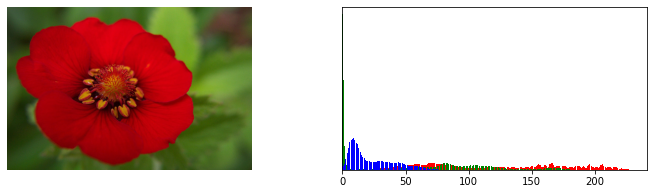

Quantidade de cores que serão consideradas:3
Imagem e seu respectivo histograma:


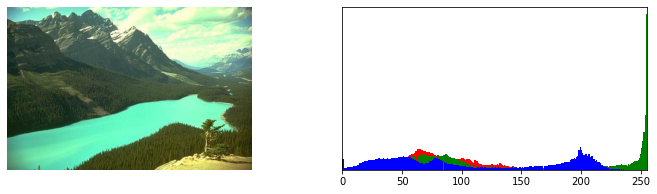

Quantidade de cores que serão consideradas:2
Imagem e seu respectivo histograma:


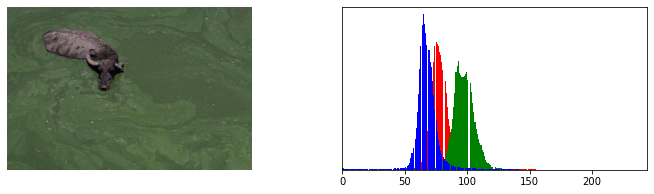

Quantidade de cores que serão consideradas:3
Imagem e seu respectivo histograma:


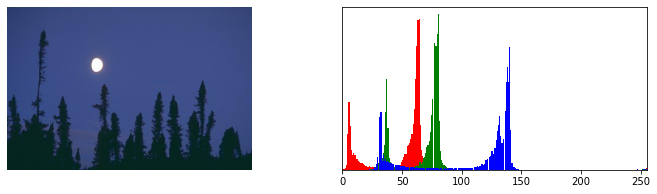

Quantidade de cores que serão consideradas:4
Imagem e seu respectivo histograma:


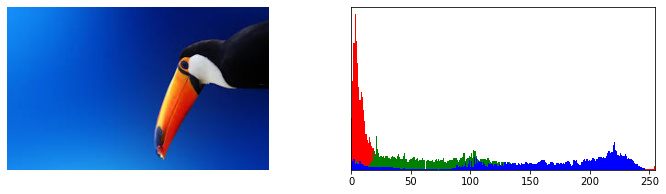

Quantidade de cores que serão consideradas:3
Imagem e seu respectivo histograma:


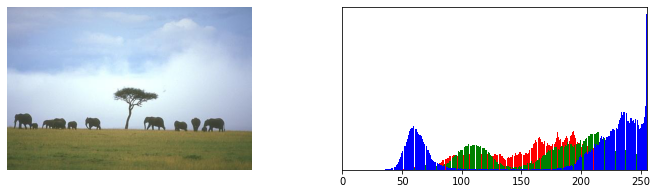

Quantidade de cores que serão consideradas:4
Imagem e seu respectivo histograma:


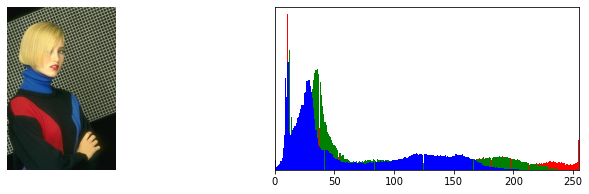

Quantidade de cores que serão consideradas:3
Imagem e seu respectivo histograma:


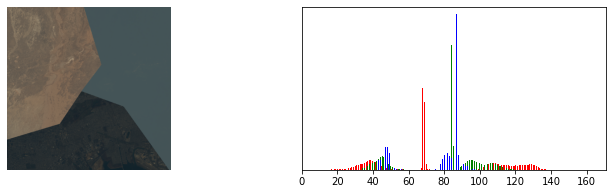

Quantidade de cores que serão consideradas:6
Imagem e seu respectivo histograma:


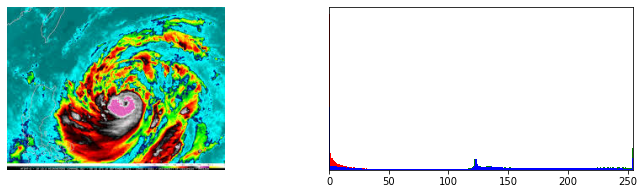

Quantidade de cores que serão consideradas:2
Imagem e seu respectivo histograma:


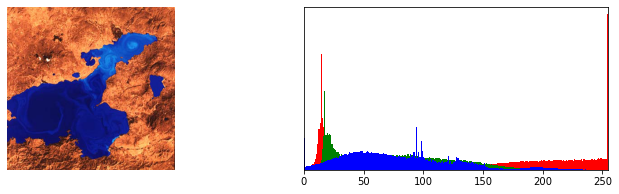

In [32]:
def ShowImageHistogram(img):
    # Display the image.
    fig, (ax1, ax2) = plt.subplots(1, 2,
                                   figsize=(12, 3))

    ax1.imshow(img, cmap=plt.cm.gray)
    ax1.set_axis_off()

    # Display the histogram.
    ax2.set_xlim(0, img.max())
    ax2.set_yticks([])
    color = [ 'r','g','b']
    for i, c in enumerate(color) :
        plt.hist(img[:,:,i].flatten(),256, color=c)
    plt.show()
    
data_path = os.path.join(imagePath,'*g') 
files = glob.glob(data_path) 
images = [] 
labelNumbers = []
for f1 in files: 
    img = io.imread(f1) 
    images.append(img)
    labelNumbers.append(f1.split("ImagensTeste/")[1].split("-")[0])
    print("Quantidade de cores que serão consideradas:" + str(f1.split("ImagensTeste/")[1].split("-")[0]))
    print("Imagem e seu respectivo histograma:")
    ShowImageHistogram(img)


Imagem Original:


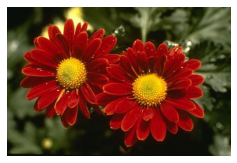

Imagem segmentada:


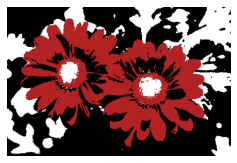

Imagem Original:


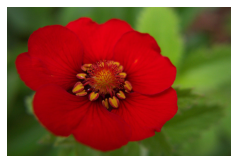

Imagem segmentada:


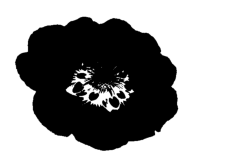

Imagem Original:


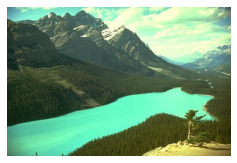

Imagem segmentada:


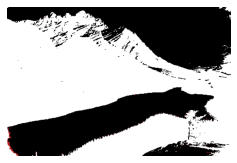

Imagem Original:


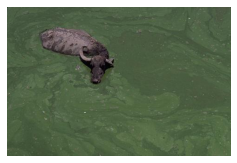

Imagem segmentada:


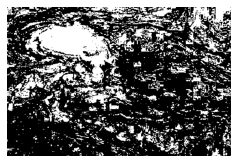

Imagem Original:


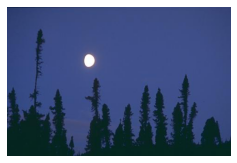

Imagem segmentada:


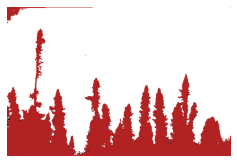

Imagem Original:


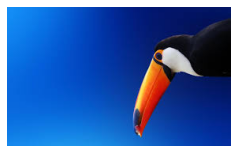

Imagem segmentada:


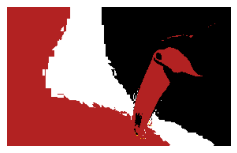

Imagem Original:


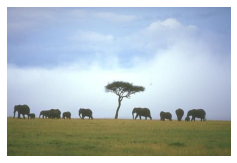

Imagem segmentada:


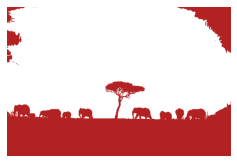

Imagem Original:


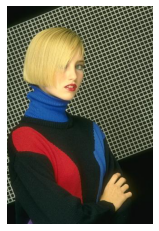

Imagem segmentada:


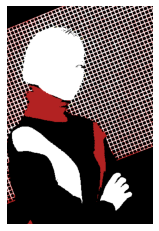

Imagem Original:


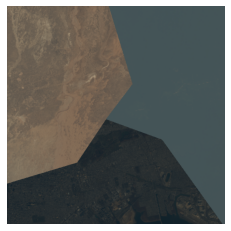

Imagem segmentada:


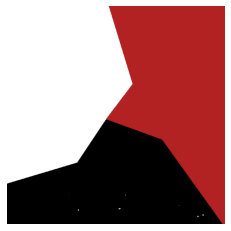

Imagem Original:


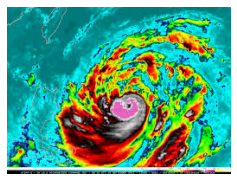

Imagem segmentada:


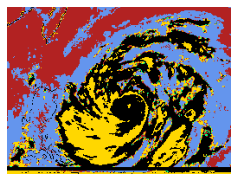

Imagem Original:


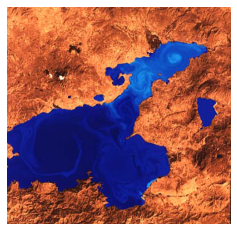

Imagem segmentada:


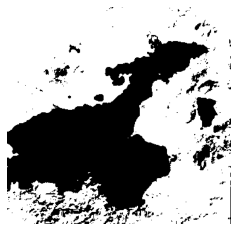

In [33]:
for i in range(len(images)):
    img = images[i]
    print("Imagem Original:")
    Show(img)
    newShape = img.shape[0]*img.shape[1]
    reshapedImg = img.reshape((newShape, -1))
    epsilon = 0.9
    r = 2
    c = int(labelNumbers[i])
    imageU, imagecentroid = fuzzy_c_means(reshapedImg, c, epsilon, r)
    imageDf = pd.DataFrame(imageU)
    imageMaxValuesObj = imageDf.idxmax(axis=1)
    mask = imageMaxValuesObj.to_numpy()
    imageMask = []
    for i in range(len(mask)):
        for j in range(c):
             if(mask[i] == j):
                    imageMask.append(maskColor[j])
    imageMask = np.array(imageMask)
    imageMask = imageMask.reshape(img.shape[0], img.shape[1], 3)
    print("Imagem segmentada:")
    Show(imageMask)